# Amazon Fine Food Reviews Analysis

## 1. Import Library

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns

import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm

import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

## 2.Loading Data

In [2]:
filtered_data = pd.read_csv('./5001 Project/Reviews.csv',nrows=100000)

# Assign reviews with Score>3 a positive label(1), and reviews with a score<3 a negative label(0).
def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = int(df[df['Score']==1].shape[0]);
    negCount = int(df[df['Score']==0].shape[0]);
    if negCount < posCount:
        return negCount
    return posCount

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Performing Downsampling
# samplingCount = findMinorClassPoints(filtered_data)
# postive_df = filtered_data[filtered_data['Score'] == 1].sample(n=5000)
# negative_df = filtered_data[filtered_data['Score'] == 0].sample(n=5000)

# filtered_data = pd.concat([postive_df, negative_df])

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."


## 3. Data Preprocessing

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

#Removing the anamolies
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # nltk stopwords list
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = str(sentence)
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # Reference from https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

100%|█████████████████████████████████████████████████████████████████████████| 88461/88461 [00:00<00:00, 89206.87it/s]


Segregating the input and output data from the dataset.

We will be using the Cleaned Text i.e preprocessed data from the dataset and score for that text

In [4]:
X = final['CleanedText']
y = final['Score']

In [5]:
del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data

### Splitting the data

In [6]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (56614,)
Shape of Output - Train: (56614,)
Shape of Input  - CV   : (14154,)
Shape of Output - CV   : (14154,)
Shape of Input  - Test : (17693,)
Shape of Output - Test : (17693,)


### Tokenizing the dataset

In [7]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[2, 49, 778, 4, 381, 302, 983, 2, 409, 7, 99, 9, 80, 20, 10, 368, 421, 13, 508, 3, 296, 24, 5, 2, 807, 5, 63, 189, 365, 6, 28, 3, 76, 6, 63, 2, 49, 463, 381, 302, 782, 3, 1654, 14, 6, 26, 11, 53, 2, 49, 548, 5, 689, 360, 202, 80, 5, 6, 26, 153, 63, 189, 11, 53]
56614


### Padding the dataset with Differnt Max Sequence Length 

This is to give batch input to the LSTM

In [8]:
# Truncate and/or pad input sequences
# Changing different Max Sequence Length as the input to do the experiment 
# max_review_length = 1000
max_review_length = 600
# max_review_length = 130
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(56614, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [9]:
# This function is used to update the plots for each epoch and error
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334S
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

### Model M1 ( Embedding -> LSTM -> Output(Sigmoid) ) 

In [10]:
# create the model M1
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


In [11]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

Epoch 1/5
111/111 [==============================] - 291s 3s/step - loss: 0.3506 - accuracy: 0.8657 - val_loss: 0.2137 - val_accuracy: 0.9086
Epoch 2/5
111/111 [==============================] - 430s 4s/step - loss: 0.1809 - accuracy: 0.9256 - val_loss: 0.1916 - val_accuracy: 0.9214
Epoch 3/5
111/111 [==============================] - 441s 4s/step - loss: 0.1584 - accuracy: 0.9361 - val_loss: 0.1963 - val_accuracy: 0.9185
Epoch 4/5
111/111 [==============================] - 448s 4s/step - loss: 0.1481 - accuracy: 0.9401 - val_loss: 0.2031 - val_accuracy: 0.9141
Epoch 5/5
35/35 [==============================] - 19s 539ms/step - loss: 0.1962 - accuracy: 0.9192
Test score: 0.19623444974422455
Test accuracy: 0.9192336201667786


NameError: name 'f1_score' is not defined

### Model M2 ( Embedding -> LSTM -> Dropout -> Dense(128-Relu) -> Dropout -> Dense (64-Relu) -> Dropout -> Output(Sigmoid) ) 

In [ ]:
# create the mode lM2
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 2,
                                    "Architecture": 'Embedding-LSTM-Dropout-Dense(128-Relu)-Dropout-Dense(64-Relu)-Dropout-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M3 ( Embedding -> LSTM -> LSTM -> Output(Sigmoid) ) 

In [ ]:
# create the model M3
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 3,
                                    "Architecture": 'Embedding-LSTM-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M4 ( Embedding -> LSTM -> LSTM -> Output(Sigmoid) )

In [ ]:
# create the model M4
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 4,
                                    "Architecture": 'Embedding-LSTM-LSTM-Sigmoid(input_length=130)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M5 ( Embedding -> LSTM -> Output(Sigmoid)) (Max Sequence Length=130)

In [82]:
# create the model M5
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 32)           160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


In [83]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 5,
                                    "Architecture": 'Embedding-LSTM-Sigmoid(input_length=130)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

Epoch 1/5
111/111 [==============================] - 165s 1s/step - loss: 0.3525 - accuracy: 0.8649 - val_loss: 0.2195 - val_accuracy: 0.9054
Epoch 2/5
111/111 [==============================] - 157s 1s/step - loss: 0.1869 - accuracy: 0.9221 - val_loss: 0.1833 - val_accuracy: 0.9238
Epoch 3/5
111/111 [==============================] - 154s 1s/step - loss: 0.1613 - accuracy: 0.9345 - val_loss: 0.1843 - val_accuracy: 0.9252
Epoch 4/5
111/111 [==============================] - 155s 1s/step - loss: 0.1522 - accuracy: 0.9389 - val_loss: 0.1857 - val_accuracy: 0.9249
Epoch 5/5
35/35 [==============================] - 17s 486ms/step - loss: 0.2056 - accuracy: 0.9153
Test score: 0.20555901527404785
Test accuracy: 0.9153337478637695
F1-score:  0.949963257398624
Testing Accuracy of the model :  0.9153337478098683


KeyError: 'acc'

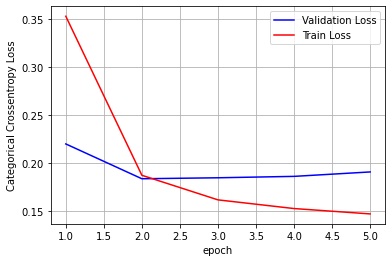

In [84]:
final_output = final_output.append({"Model": 5,
                                    "Architecture": 'Embedding-LSTM-Sigmoid(input_length=130)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M6 ( Embedding -> LSTM -> Output(Sigmoid) )(Max Sequence Length=600) 

In [20]:
# create the model M6
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Epoch 1/5
111/111 [==============================] - 1705s 15s/step - loss: 0.3703 - accuracy: 0.8617 - val_loss: 0.2130 - val_accuracy: 0.9117
Epoch 2/5
111/111 [==============================] - 1607s 14s/step - loss: 0.2149 - accuracy: 0.9109 - val_loss: 0.1960 - val_accuracy: 0.9173
Epoch 3/5
111/111 [==============================] - 1615s 15s/step - loss: 0.1702 - accuracy: 0.9300 - val_loss: 0.1835 - val_accuracy: 0.9249
Epoch 4/5
111/111 [==============================] - 1631s 15s/step - loss: 0.1555 - accuracy: 0.9379 - val_loss: 0.1910 - val_accuracy: 0.9250
Epoch 5/5
35/35 [==============================] - 90s 3s/step - loss: 0.1975 - accuracy: 0.9204
Test score: 0.1975172609090805
Test accuracy: 0.9204205274581909
F1-score:  0.953473002445311
Testing Accuracy of the model :  0.9204205052845759


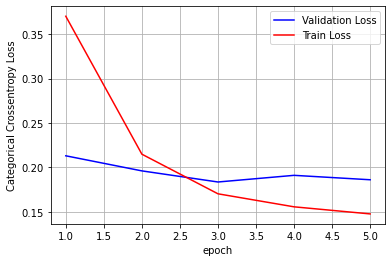

In [21]:

m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))
score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 6,
                                    "Architecture": 'Embedding-LSTM-Sigmoid(input_length=600)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M7 ( Embedding -> LSTM -> LSTM ->Output(Sigmoid) )(Max Sequence Length=600) 

In [78]:
# create the model M7
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Epoch 1/5
111/111 [==============================] - 4043s 36s/step - loss: 0.3425 - accuracy: 0.8710 - val_loss: 0.2082 - val_accuracy: 0.9129
Epoch 2/5
111/111 [==============================] - 3950s 36s/step - loss: 0.1854 - accuracy: 0.9238 - val_loss: 0.1868 - val_accuracy: 0.9227
Epoch 3/5
111/111 [==============================] - 3653s 33s/step - loss: 0.1599 - accuracy: 0.9351 - val_loss: 0.1791 - val_accuracy: 0.9253
Epoch 4/5
111/111 [==============================] - 3666s 33s/step - loss: 0.1486 - accuracy: 0.9399 - val_loss: 0.1821 - val_accuracy: 0.9256
Epoch 5/5
35/35 [==============================] - 191s 5s/step - loss: 0.1974 - accuracy: 0.9213
Test score: 0.1974116861820221
Test accuracy: 0.9212682843208313
F1-score:  0.9537869488770196
Testing Accuracy of the model :  0.921268298197027


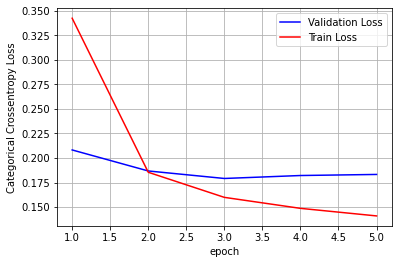

In [79]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 7,
                                    "Architecture": 'Embedding-LSTM-LSTM-Sigmoid(input_length=600)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M8 ( Embedding -> LSTM -> LSTM -> LSTM-> Output(Sigmoid) )

In [15]:
# create the model M8
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 100)         53200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 100)         80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 374,101
Trainable params: 374,101
Non-trainable params: 0
_________________________________________________________________
None
************************************

In [16]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 8,
                                    "Architecture": 'Embedding -> LSTM -> LSTM -> LSTM-> Output(Sigmoid)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

Epoch 1/5
111/111 [==============================] - 5514s 50s/step - loss: 0.3358 - accuracy: 0.8733 - val_loss: 0.2116 - val_accuracy: 0.9098
Epoch 2/5
111/111 [==============================] - 7528s 68s/step - loss: 0.1848 - accuracy: 0.9250 - val_loss: 0.1847 - val_accuracy: 0.9226
Epoch 3/5
111/111 [==============================] - 24884s 224s/step - loss: 0.1608 - accuracy: 0.9341 - val_loss: 0.1804 - val_accuracy: 0.9257
Epoch 4/5
111/111 [==============================] - 16812s 151s/step - loss: 0.1470 - accuracy: 0.9417 - val_loss: 0.1902 - val_accuracy: 0.9234
Epoch 5/5
35/35 [==============================] - 540s 15s/step - loss: 0.2040 - accuracy: 0.9223
Test score: 0.20396316051483154
Test accuracy: 0.9223421812057495


KeyError: 'acc'

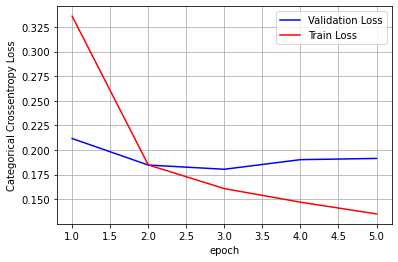

In [17]:
# final_output = final_output.append({"Model": 8,
#                                     "Architecture": 'Embedding -> LSTM -> LSTM -> LSTM-> Output(Sigmoid)', 
#                                     "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
#                                     "TEST_LOSS": '{:.5f}'.format(score[0]),
#                                     "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
#                                     "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('epoch')
# ax.set_ylabel('Categorical Crossentropy Loss')

# # list of epoch numbers
# x = list(range(1,n_epochs+1))

# vy = m_hist.history['val_loss']
# ty = m_hist.history['loss']
# plt_dynamic(x, vy, ty, ax)

In [18]:
# from sklearn.metrics import f1_score,accuracy_score
# prediction = model.predict(X_test_new)
# y_pred = (prediction > 0.5)
# print('F1-score: ', f1_score(y_pred, y_test))
# print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

F1-score:  0.9547192196150803
Testing Accuracy of the model :  0.9223421692194653


### Model M9 ( Embedding ->BN->Dropout->  LSTM -> Output(Sigmoid) )

In [ ]:
# create the model M9
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 9,
                                    "Architecture": 'Embedding ->BN->Dropout->LSTM -> Output(Sigmoid)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M10 ( Embedding ->BN->Dropout->  LSTM ->Dropout->LSTM ->Dropout-> Output(Sigmoid) )

In [ ]:
# create the model M10
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 10,
                                    "Architecture": 'Embedding ->BN->Dropout-> LSTM ->Dropout->LSTM ->Dropout-> Output(Sigmoid)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M11 ( Embedding ->BN->Dropout->  LSTM -> Output( Relu ) )

In [ ]:
# create the model M11
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='Relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 11,
                                    "Architecture": 'Embedding->BN->Dropout->LSTM->Dropout->LSTM->Dropout->Output(Sigmoid)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M13 ( Embedding -> LSTM -> LSTM -> LSTM-> Output(Sigmoid)) (Max Sequence Length=130)

In [86]:
# create the model M13
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 130, 32)           160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 130, 100)          53200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 130, 100)          80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 374,101
Trainable params: 374,101
Non-trainable params: 0
_________________________________________________________________
None
**********************************

Epoch 1/5
111/111 [==============================] - 644s 6s/step - loss: 0.3441 - accuracy: 0.8687 - val_loss: 0.2217 - val_accuracy: 0.9072
Epoch 2/5
111/111 [==============================] - 648s 6s/step - loss: 0.1858 - accuracy: 0.9229 - val_loss: 0.1853 - val_accuracy: 0.9216
Epoch 3/5
111/111 [==============================] - 636s 6s/step - loss: 0.1581 - accuracy: 0.9354 - val_loss: 0.1829 - val_accuracy: 0.9221
Epoch 4/5
111/111 [==============================] - 667s 6s/step - loss: 0.1460 - accuracy: 0.9414 - val_loss: 0.1825 - val_accuracy: 0.9257
Epoch 5/5
35/35 [==============================] - 56s 2s/step - loss: 0.2052 - accuracy: 0.9200
Test score: 0.20524831116199493
Test accuracy: 0.9200248718261719
F1-score:  0.9534401632062125
Testing Accuracy of the model :  0.9200248685920985


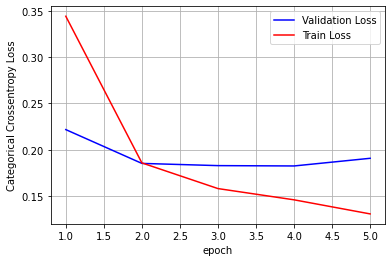

In [87]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 13,
                                    "Architecture": 'Embedding-LSTM-LSTM-LSTM-Sigmoid(input_length=130)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M14 ( Embedding -> LSTM -> LSTM -> LSTM-> Output(Sigmoid)) (Max Sequence Length=130)

In [89]:
# create the model M14
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 600, 100)          80400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 374,101
Trainable params: 374,101
Non-trainable params: 0
_________________________________________________________________
None
**********************************

Epoch 1/5
111/111 [==============================] - 5269s 47s/step - loss: 0.2139 - accuracy: 0.9117 - val_loss: 0.1952 - val_accuracy: 0.9196
Epoch 2/5
111/111 [==============================] - 5884s 53s/step - loss: 0.1682 - accuracy: 0.9321 - val_loss: 0.1914 - val_accuracy: 0.9228
Epoch 3/5
111/111 [==============================] - 6343s 57s/step - loss: 0.1539 - accuracy: 0.9383 - val_loss: 0.1857 - val_accuracy: 0.9223
Epoch 4/5
111/111 [==============================] - 5817s 52s/step - loss: 0.1429 - accuracy: 0.9425 - val_loss: 0.2029 - val_accuracy: 0.9248
Epoch 5/5
35/35 [==============================] - 287s 8s/step - loss: 0.2121 - accuracy: 0.9128
Test score: 0.2120521515607834
Test accuracy: 0.9127903580665588
F1-score:  0.9492150215581082
Testing Accuracy of the model :  0.9127903690725145


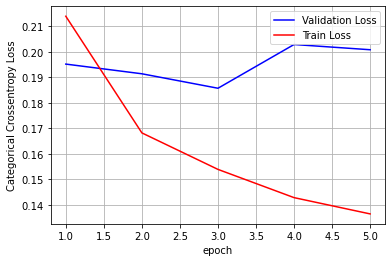

In [91]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

prediction = model.predict(X_test_new)
y_pred = (prediction > 0.5)
print('F1-score: ', f1_score(y_pred, y_test))
print("Testing Accuracy of the model : ", accuracy_score(y_pred, y_test))

final_output = final_output.append({"Model": 14,
                                    "Architecture": 'Embedding-LSTM-LSTM-LSTM-Sigmoid(input_length=600)', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [ ]:
final_output